# OCR com transfer learning usando a MobileNetV2

Por: Augusto Ribeiro Castro - 9771421



Importanto bibliotecas úteis

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
import numpy as np

!pip install -q -U tensorflow_hub
import tensorflow_hub as hub

from tensorflow.keras import layers

Download do dataset, descompactação dos arquivos e colocação dos dados dentro de uma pasta persistente na seção do Colab

### Download dos caracteres em imagens


Apenas as imagens caracterizadas como boas serão utilizadas

In [0]:
_URL = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz'

path_to_zip = tf.keras.utils.get_file('EnglishImg.tgz', origin=_URL, extract=True)

import os

PATH = os.path.join(os.path.dirname(path_to_zip), 'English/Img/GoodImg/Bmp')

import shutil

if(os.path.isdir('/content/Img')):
  shutil.rmtree('/content/Img')
  

shutil.move(PATH, '/content/Img')


#os.unlink('/content/Img/all.txt~')

data_root = '/content/Img'

Renomeando as pastas para os nomes dos caracteres, que serão usados como labels:

In [0]:
labels_num = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
labels_upperletters = ['Upper_A', 'Upper_B', 'Upper_C', 'Upper_D', 'Upper_E', 'Upper_F', 'Upper_G', 'Upper_H', 'Upper_I', 'Upper_J', 'Upper_K', 'Upper_L', 'Upper_M', 'Upper_N', 'Upper_O', 'Upper_P', 'Upper_Q', 'Upper_R', 'Upper_S', 'Upper_T', 'Upper_U', 'Upper_V', 'Upper_W', 'Upper_X', 'Upper_Y', 'Upper_Z']
labels_lowerletters = ['Lower_a', 'Lower_b', 'Lower_c', 'Lower_d', 'Lower_e', 'Lower_f', 'Lower_g', 'Lower_h', 'Lower_i', 'Lower_j', 'Lower_k', 'Lower_l', 'Lower_m', 'Lower_n', 'Lower_o', 'Lower_p', 'Lower_q', 'Lower_r', 'Lower_s', 'Lower_t', 'Lower_u', 'Lower_v', 'Lower_w', 'Lower_x', 'Lower_y', 'Lower_z']

name_dirs = os.listdir('/content/Img')
name_dirs.sort()

for i in range (len(name_dirs)):
  if i < len(labels_num):
    os.rename(data_root+'/'+name_dirs[i], data_root+'/'+labels_num[i])
  elif i-10 < 26:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_upperletters[i-10])
  else:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_lowerletters[i-36])




### Download dos caracteres escritos a mão

In [0]:
_URL = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz'

path_to_zip = tf.keras.utils.get_file('EnglishHnd.tgz', origin=_URL, extract=True)

import os

PATH = os.path.join(os.path.dirname(path_to_zip), 'English/Hnd/Img')

import shutil

if(os.path.isdir('/content/Hnd')):
  shutil.rmtree('/content/Hnd')
  

shutil.move(PATH, '/content/Hnd')


os.unlink('/content/Hnd/all.txt~')

data_root = '/content/Hnd'

Formatação do diretório de letras escritas a mão com os labels corretos

In [0]:
name_dirs = os.listdir('/content/Hnd')
name_dirs.sort()

for i in range (len(name_dirs)):
  if i < len(labels_num):
    os.rename(data_root+'/'+name_dirs[i], data_root+'/'+labels_num[i])
  elif i-10 < 26:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_upperletters[i-10])
  else:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_lowerletters[i-36])



Mover arquivos dos diretórios de imagens escritas à mão para as respectivas pastas dentro das imagens (merge dos datasets)

In [0]:
hnd_dirs = os.listdir('/content/Hnd')
img_dirs = os.listdir('/content/Img')

for _dir in hnd_dirs:
  dir_files = os.listdir('/content/Hnd/'+_dir)
  for file in dir_files:
    shutil.move('/content/Hnd/'+_dir+'/'+file, '/content/Img/'+_dir+'/'+file)
  
  
data_root = '/content/Img'

### Download dos caracteres baseados em fontes de computador

In [0]:
_URL = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz'

path_to_zip = tf.keras.utils.get_file('EnglishFnt.tgz', origin=_URL, extract=True)

import os

PATH = os.path.join(os.path.dirname(path_to_zip), 'English/Fnt/')

import shutil

if(os.path.isdir('/content/Fnt')):
  shutil.rmtree('/content/Fnt')
  

shutil.move(PATH, '/content/Fnt')


data_root = '/content/Fnt'

In [0]:
name_dirs = os.listdir('/content/Fnt')
name_dirs.sort()

for i in range (len(name_dirs)):
  if i < len(labels_num):
    os.rename(data_root+'/'+name_dirs[i], data_root+'/'+labels_num[i])
  elif i-10 < 26:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_upperletters[i-10])
  else:
    os.rename(data_root+'/'+name_dirs[i],  data_root+'/'+labels_lowerletters[i-36])


In [0]:
hnd_dirs = os.listdir('/content/Fnt')
img_dirs = os.listdir('/content/Img')

for _dir in hnd_dirs:
  dir_files = os.listdir('/content/Fnt/'+_dir)
  for file in dir_files:
    shutil.move('/content/Fnt/'+_dir+'/'+file, '/content/Img/'+_dir+'/'+file)
  
  
data_root = '/content/Img'

### Carregamento dos dados e divisão em lotes: 70% do conjunto para treino e 30% para validação

Função que converte de RGB para escala de cinza e replica o resultado para os três canais de cor

In [0]:
def pre_process(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  
    rgb[:, :, 0] = gray
    rgb[:, :, 1] = gray
    rgb[:, :, 2] = gray
    return rgb
  

In [0]:
IMAGE_SHAPE = (224, 224)


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split = 0.3, preprocessing_function=pre_process)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, subset = 'training')
image_validation = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, subset = 'validation')

Found 46500 images belonging to 62 classes.
Found 19902 images belonging to 62 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 62)


Download do classificador sem a camada final para o transfer learning

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(32, 1280)


In [0]:
feature_extractor_layer.trainable = False


Adicionando camada densa ao final da camada da MobileNetV2 de extração de características

Foi escolhida como função de ativação a 'softmax' conforme feito no tutorial e a camada densa possui o mesmo tamanho do número de classes de caracteres

A função softmax recebe como entrada um vetor de valores reais e normaliza-os em uma distribuição de probabilidades proporcional à exponencial do valor de entrada

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 62)                31806     
Total params: 2,945,662
Trainable params: 687,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

predictions.shape

TensorShape([Dimension(32), Dimension(62)])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])


In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


Treinamento da rede

In [0]:
_epochs = 10
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=_epochs,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback], validation_data=image_validation)


Epoch 1/10
1454/1454 [==============================] - 193s 133ms/step - loss: 1.0789 - acc: 0.8125 - val_loss: 0.6780 - val_acc: 0.7880
Epoch 2/10
1454/1454 [==============================] - 186s 128ms/step - loss: 0.6327 - acc: 0.7188 - val_loss: 0.6169 - val_acc: 0.8008
Epoch 3/10
1454/1454 [==============================] - 186s 128ms/step - loss: 0.5194 - acc: 0.7500 - val_loss: 0.5959 - val_acc: 0.8036
Epoch 4/10
1454/1454 [==============================] - 187s 128ms/step - loss: 0.4452 - acc: 0.8125 - val_loss: 0.5839 - val_acc: 0.8096
Epoch 5/10
1454/1454 [==============================] - 186s 128ms/step - loss: 0.4086 - acc: 0.7812 - val_loss: 0.5711 - val_acc: 0.8271
Epoch 6/10
1454/1454 [==============================] - 186s 128ms/step - loss: 0.3679 - acc: 0.7812 - val_loss: 0.5878 - val_acc: 0.8240
Epoch 7/10
1454/1454 [==============================] - 186s 128ms/step - loss: 0.3434 - acc: 0.8438 - val_loss: 0.5882 - val_acc: 0.8208
Epoch 8/10
1454/1454 [============

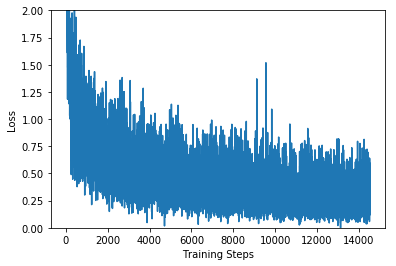

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


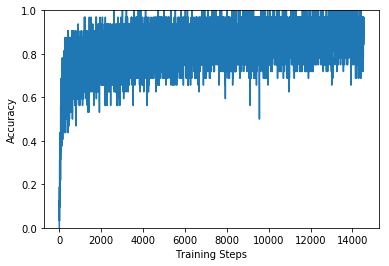

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


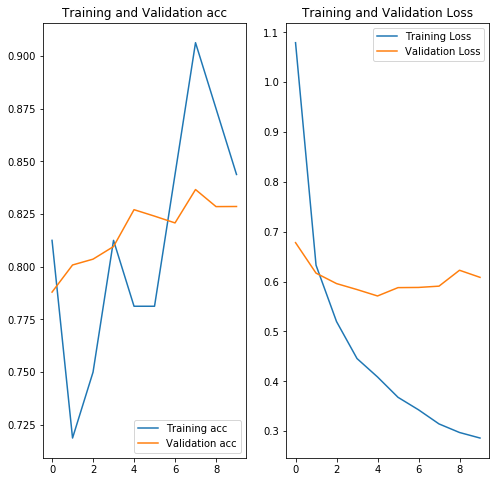

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = _epochs
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training acc')
plt.plot(epochs_range, val_acc, label='Validation acc')
plt.legend(loc='lower right')
plt.title('Training and Validation acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Visualizar previsões sobre conjunto de treino

In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Lower_A',
       'Lower_B', 'Lower_C', 'Lower_D', 'Lower_E', 'Lower_F', 'Lower_G',
       'Lower_H', 'Lower_I', 'Lower_J', 'Lower_K', 'Lower_L', 'Lower_M',
       'Lower_N', 'Lower_O', 'Lower_P', 'Lower_Q', 'Lower_R', 'Lower_S',
       'Lower_T', 'Lower_U', 'Lower_V', 'Lower_W', 'Lower_X', 'Lower_Y',
       'Lower_Z', 'Upper_A', 'Upper_B', 'Upper_C', 'Upper_D', 'Upper_E',
       'Upper_F', 'Upper_G', 'Upper_H', 'Upper_I', 'Upper_J', 'Upper_K',
       'Upper_L', 'Upper_M', 'Upper_N', 'Upper_O', 'Upper_P', 'Upper_Q',
       'Upper_R', 'Upper_S', 'Upper_T', 'Upper_U', 'Upper_V', 'Upper_W',
       'Upper_X', 'Upper_Y', 'Upper_Z'], dtype='<U7')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


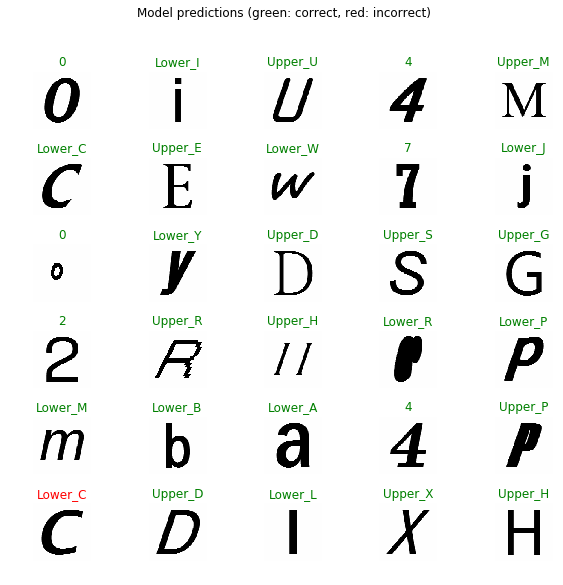

In [0]:
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


## Visualizar previsões sobre conjunto de validação

In [0]:
class_names = sorted(image_validation.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Lower_A',
       'Lower_B', 'Lower_C', 'Lower_D', 'Lower_E', 'Lower_F', 'Lower_G',
       'Lower_H', 'Lower_I', 'Lower_J', 'Lower_K', 'Lower_L', 'Lower_M',
       'Lower_N', 'Lower_O', 'Lower_P', 'Lower_Q', 'Lower_R', 'Lower_S',
       'Lower_T', 'Lower_U', 'Lower_V', 'Lower_W', 'Lower_X', 'Lower_Y',
       'Lower_Z', 'Upper_A', 'Upper_B', 'Upper_C', 'Upper_D', 'Upper_E',
       'Upper_F', 'Upper_G', 'Upper_H', 'Upper_I', 'Upper_J', 'Upper_K',
       'Upper_L', 'Upper_M', 'Upper_N', 'Upper_O', 'Upper_P', 'Upper_Q',
       'Upper_R', 'Upper_S', 'Upper_T', 'Upper_U', 'Upper_V', 'Upper_W',
       'Upper_X', 'Upper_Y', 'Upper_Z'], dtype='<U7')

In [0]:
for image_batch, label_batch in image_validation:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 62)


In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

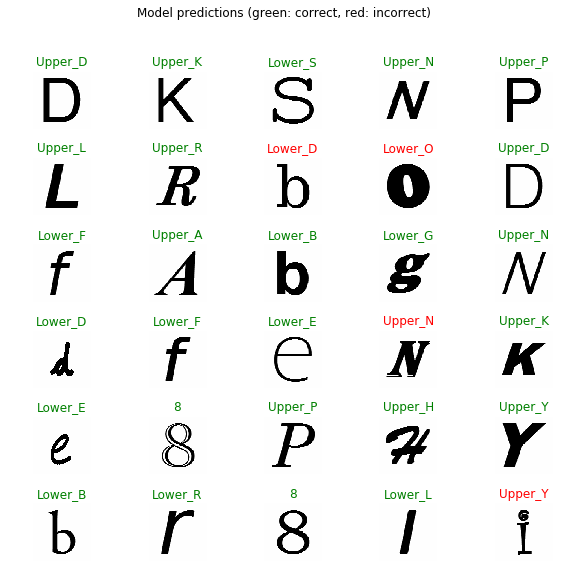

In [0]:
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
